# Milestone 2 - Data gathering and preprocessing

## 1. Narrowing down the research question

### Research Questions

In this research project we will try to analyse a corpus of popular songs to try to identify  chords differences between verses and choruses. We will try to  answer the following research questions :
<ol>
<li>Does the chord distribution of the choruses differ from the one in the verses?</li>
<li>Is there a different chord sequence distribution in the choruses compared to the verses?</li>
<li>How are these distributions evolving over time? </li>
</ol>

In the first question we want to know if a difference exists in terms of chords statistic. Are we more likely to find a specific chord in the choruses? Are fewer different chords used in the chorus compared to the other parts of a song? <br> 
For the second one we want to have a more melodic insight. Can we find specific patterns? Is the Markov model derived from the chorus different from its counterparts? <br>
In the third one the focus is on the time dimension. We want to know if the results of the two previous answers change over time. Were chorus closer to verses in 1968 than in 1985? How does each chord evolve in relation to the others? Do we find a sequence that appeared while other disappeared? 

These are all the underlying questions we want to answer under our main research questions.  

These questions relate to our original idea to fully characterize a chorus over the years, especially in comparison with verses. We now want to focus specifically on the chords to differentiate these different parts, while keeping the temporal dimension as a potential factor to observe changes.

### Dataset presentation

To give us the means to answer our questions, we have selected a dataset containing approximately 900 Pop-Rock songs in the top Billboard charts from the 60s to the 90s. They are simple text files with the following informations : 
* Release date
* Song title 
* Artist name
* Labels for the different parts of the song (such as chorus or verse)
* Timestamp of each musical phrase beginning
* Chords

### Procedure

We will use the chorus/verse annotations to classify the chords in each group. This will allow us to divide the chords in two groups and compute statistics and distributions for each of them. As discussed in the research questions, we will start with a basic characterization, simply comparing which chords appear in which section. We will then move deeper and compare the distributions of chords as well as the Markov models. These will be computed at least with bigrams, perhaps with higher-n n-grams depending on the number of chords in each section (as it makes little sense to use n-grams with n close to the number of chords in a given section).

The metadata, especially the release date, will be used to study the evolution over time of the previously discussed statistics. Depending on the distribution of songs over the years, time analysis will be discussed either over years or over decades.

### Possible outcomes and confidence measures

The different outcomes we can reasonably expect are: 
<ul>
    <li> <strong>Null results:</strong> There are no significant differences between choruses and verses and no evolution over time. This could be explained by a bias in the corpus toward a specific Pop-Rock genre using the same chords all the time or maybe there is indeed no difference in the chords used in a chorus and the ones used in verses, which would constitute an answer for our questions. </li>
<li> <strong>Narrow chorus chord distribution:</strong> Since the chorus has to be immediately recognized as one, maybe the composers make more extensive use of a sub group of the chords to ensure it. The same reasoning could be applied to the chord sequences: perhaps some specific ones will be more dominant in the chorus.</li>
<li> <strong>Temporal evolution:</strong> It will be interesting to see if the differences between verse and chorus change over the years. This evolution, if present, could be linear or oscillating. A linear narrowing would imply that choruses are becoming more and more similar or verse more and more diverse. An oscillating pattern would be interesting as musical phenomenon could appear and disappear.</li>
</ul>

Statistical tests will be used throughtout our analysis to check if our findings are statistically relevant. Error bars will also be included in all our graphics to avoid wrong conclusions. Of course the relative small size of our corpus will influence our results but only further analysis can reveal if significant results can still be found.

## 2. Gathering the data
The dataset has been created by [1] and corresponds to a random sample of 890 Billboard chart slots presented at ISMIR 2011 and MIREX 2012. Due to the nature of the sampling algorithm, there are some duplicates and this results in only 740 distinct songs. According to the authors, training algorithms that assume independent, identically distributed data should retain the duplicates.<br> This dataset is publicly available at https://ddmal.music.mcgill.ca/research/The_McGill_Billboard_Project_(Chord_Analysis_Dataset)/ and can be downloaded in various formats. Different features are given by the authors. In this project we will use metadata and chords annotations. 
The first dataset used is the index to the dataset (csv format), containing the following fields:
<ul>
<li><b>id</b>, the index for the sample entry.</li>
<li><b>chart_date</b>, the date of the chart for the entry.</li>
<li><b>target_rank</b>, the desired rank on that chart.</li>
<li><b>actual_rank</b>, the rank of the song actually annotated, which may be up to 2 ranks higher or lower than the target rank [1, 2].</li>
<li><b>title</b>, the title of the song annotated.</li>
<li><b>artist</b>, the name of the artist performing the song annotated.</li>
<li><b>peak_rank</b>, the highest rank the song annotated ever achieved on the Billboard Hot 100.</li>
<li><b>weeks_on_chart</b>, the number of weeks the song annotated spent on the Billboard Hot 100 chart in total.</li>
</ul>

The main dataset comprehends chords, structure, instrumentation, and timing, given in a txt format. The annotation for each song begins with a header containing the title of the song, the name of the artist, the metre and the tonic pitch class of the opening key. In the main body, each line consists of a single phrase and begins with its timestamp, followed by the chords. This requires us to design a specific parser, as will be discussed in the next section.<br>
We downloaded the two datasets which constitutes the whole of their database so we have the maximum from this source. It is not excluded that we find some additional ones to perform further analysis. As for now we will try to get as much stastitically relevant information from this source.

[1]: John Ashley Burgoyne, Jonathan Wild, and Ichiro Fujinaga, ‘An Expert Ground Truth Set for Audio Chord Recognition and Music Analysis’, in Proceedings of the 12th International Society for Music Information Retrieval Conference, ed. Anssi Klapuri and Colby Leider (Miami, FL, 2011), pp. 633–38

## 3. Data format

The goal of this question is to load the data and have a look at it. A specific parser is designed to do this automatically, in order to extract and store in a Pandas dataframe all the relevant informations and musical features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='white')
import plotly.express as px


### Metadata

In [2]:
metadata_df = pd.read_csv("data/billboard-2.0-index.csv")
metadata_df.head(10)

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
0,1,1987-07-11,82,NaN,NaN,NaN,NaN,NaN
1,2,1973-08-04,14,NaN,NaN,NaN,NaN,NaN
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
4,5,1976-07-10,51,NaN,NaN,NaN,NaN,NaN
5,6,1980-08-02,15,16.0,The Rose,Bette Midler,3.0,25.0
6,7,1972-10-07,37,NaN,NaN,NaN,NaN,NaN
7,8,1963-04-13,67,NaN,NaN,NaN,NaN,NaN
8,9,1991-05-25,48,NaN,NaN,NaN,NaN,NaN
9,10,1984-03-24,49,51.0,An Innocent Man,Billy Joel,10.0,18.0


In [3]:
print('There are %d entries in the index table.' %len(metadata_df))

There are 1300 entries in the index table.


In [4]:
print('There are %d entries with a given title.' %metadata_df.title.isna().value_counts()[0])

There are 890 entries with a given title.


In [5]:
print('There are %d entries with a given artist.' %metadata_df.artist.isna().value_counts()[0])

There are 890 entries with a given artist.


In [6]:
print('There are %d entries with a given chart date.' %metadata_df.chart_date.isna().value_counts()[0])

There are 1300 entries with a given chart date.


In [7]:
months = {'01':'January', 
          '02':'February',
          '03':'March',
          '04':'April',
          '05':'May',
          '06':'June',
          '07':'July',
          '08':'August',
          '09':'September',
          '10':'October',
          '11':'November',
          '12':'December'}
def format_date(date):
    year = date[:4]
    month = date[5:7]
    day = date[-2:]
    if day == '01':
        suffix = 'st'
    elif day == '02':
        suffix = 'nd'
    elif day == '03':
        suffix = 'rd'
    else:
        suffix = 'th'
        
    if day[0] == '0':
        day = day[1]
    
    date_string = months[month] + ' ' + day + suffix + ', ' + year
    return(date_string)

#Test
format_date('1958-08-04')

'August 4th, 1958'

In [8]:
print('The songs range from %s to %s.' %(format_date(metadata_df.chart_date.min()), format_date(metadata_df.chart_date.max())))

The songs range from August 18th, 1958 to November 16th, 1991.


### Parser 

In [9]:
SONG_ID, LINE_NUMBER, MEASURE_NUMBER, CHORD_NUMBER, SEQUENCE_NUMBER, \
CHORD, INSTRUMENT, TYPE, TIME, STRUCTURE, DURATION, REPETITION, ELID = \
"song_id","line_id", "measure_id", "chord_id", "sequence_id",\
"chord", "instrument", "section_type", "time", "section_structure", "duration", "repetition", "elided"

def immutable_merge(dic1, dic2):
    result = dic1.copy()
    result.update(dic2)
    return result

def create_row(persistent_attributes, line_attributes,
               measure_number = None, chord_number = None, chord = None, duration = None):
    result = immutable_merge(persistent_attributes, line_attributes)
    
    if not (measure_number is None and measure_number is None and chord_number is None and duration is None):
        result[MEASURE_NUMBER] = measure_number
        result[CHORD_NUMBER] = chord_number
        result[CHORD] = chord
        result[DURATION] = duration
    
    return result

def process_line_metadata(header, line_counter, old_line_attributes, sequence_counter, suffix = ""):
    
    result = {}
    
    #Suffix (main instrument, elid, repetition)
    old_instrument = str(old_line_attributes.get(INSTRUMENT))
    
    for suffix in suffix.split(", "):
        
        suffix = suffix.strip()
        
        #Repetition
        if re.match("^x\d+$",suffix):
            result[REPETITION] = int(suffix[1])
        
        #Elid
        elif suffix == "->":
            result[ELID] = True

        #Instrument
        else:
            ##New instrument
            if len(suffix) > 0 and suffix != "\n":
                result[INSTRUMENT] = suffix.strip("\n").strip(",").strip()

            ##Main instrument continued (experimental)
            elif not old_instrument.endswith(")") and old_instrument.lower() not in ["nan","none"] and len(old_instrument)>0:
                result[INSTRUMENT] = old_instrument.strip("(")

        
    #Line number
    result[LINE_NUMBER] = line_counter

    
    #Header    
    header_items = header.split()
        
    result[TIME] = header_items[0]
    
    #Case where a section is continued
    if len(header_items) == 1:
        result[TYPE] = old_line_attributes.get(TYPE)
        result[STRUCTURE] = old_line_attributes.get(STRUCTURE)
        result[SEQUENCE_NUMBER] = old_line_attributes.get(SEQUENCE_NUMBER)
    
    #Case where a section has no structure (silence, end, fadeout)
    elif len(header_items) == 2:
        result[TYPE] = header_items[1].strip().strip(",")
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    #Case where a section begins.
    elif len(header_items) == 3:
        result[STRUCTURE] = header_items[1].strip().strip(",")
        result[TYPE] = header_items[2].strip().strip(",")
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    return sequence_counter, result

In [10]:
def parse_song_to_dict(song_id, path):
    
    rows = []
    persistent_attributes = {}
    
    persistent_attributes[SONG_ID] = song_id
    
    with open(path,"r") as file:
        line = file.readline()
        
        line_counter = 0
        measure_counter = 0
        chord_counter = 0
        sequence_counter = 0
        line_attributes = {}
        old_chord = None
 

        while line:
        
            if line != "\n":

                #Attribute lines
                if line.startswith("#"):
                    attribute, value = line.strip("#").split(":",1)
                    persistent_attributes[attribute.strip(" ")] = value.strip(" ").strip("\n")

                else:
                    line_items = line.split("|")

                    #Special lines
                    if len(line_items) <= 1:
                        sequence_counter, line_attributes = \
                        process_line_metadata(line, line_counter, line_attributes, sequence_counter)
                        row = create_row(persistent_attributes, line_attributes)
                        rows.append(row)

                    #Standard lines    
                    else:                    
                        header = line_items[0]
                        suffix = line_items[-1]
                        measures = line_items[1:-1]

                        sequence_counter, line_attributes = \
                        process_line_metadata(header, line_counter, line_attributes, sequence_counter, suffix)  

                        for measure in measures:
                            
                            chords = measure.split()
                            
                            if len(chords) == 1:
                                duration = "measure"
                            else:
                                duration = "beat"
                            
                            for chord in chords:
                                
                                if chord == ".":
                                    chord = old_chord
                                
                                row = create_row(persistent_attributes, line_attributes,
                                                 measure_counter, chord_counter, chord, duration)
                                rows.append(row)
                                old_chord = chord
                                chord_counter += 1

                            measure_counter += 1
            
            #Finally
            line_counter += 1
            line = file.readline()
    
    
    return rows

In [11]:
test = pd.DataFrame(parse_song_to_dict(0,"data/McGill-Billboard/0004/salami_chords.txt"))

In [12]:
def create_whole_collection_df():
    
    path = "data/McGill-Billboard/"
    file_name = "/salami_chords.txt"
    UPPER_BOUND = 1300
    
    whole_collection = []
    
    i = 0
    while i <= UPPER_BOUND:
        full_path = path + "0"*(4-len(str(i)))+ str(i) + file_name
        
        if os.path.exists(full_path):
            whole_collection += parse_song_to_dict(i, full_path)
        
        i += 1
        
    whole_collection_df = pd.DataFrame(whole_collection)
    
    return whole_collection_df.astype({SEQUENCE_NUMBER: 'Int64', MEASURE_NUMBER: 'Int64', CHORD_NUMBER: 'Int64', \
                                      REPETITION: 'Int64'})

In [13]:
collection_df = create_whole_collection_df()

In [14]:
collection_df.sample(10)

,song_id,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,measure_id,chord_id,chord,duration,instrument,elided,repetition
97067,963,The Stroke,Billy Squier,4/4,D,7,9.305827664,intro,1,A,4,4,N,measure,drums,NaN,NaN
47602,475,Daydream Believer,Anne Murray,4/4,Bb,19,102.862743764,interlude,6,A,56,78,Bb:maj,measure,(guitar),NaN,NaN
115212,1148,I Don t Want Your Love,Duran Duran,4/4,D,20,123.781995464,interlude,7,D,57,57,D:min,measure,(guitar,NaN,NaN
988,19,Here's Some Love,Tanya Tucker,4/4,Db,10,46.587755102,chorus,3,C,16,28,Db:7,beat,voice,NaN,NaN
42452,425,See See Rider,LaVern Baker,4/4,Db,23,88.397823129,solo,4,B',71,79,Db:maj,measure,saxophone,NaN,NaN
15462,170,Golden Earring,Twilight Zone,4/4,B,17,85.730702947,verse,5,C,44,44,E:min,measure,voice,NaN,NaN
112800,1121,A Hazy Shade Of Winter,Simon And Garfunel,4/4,D,15,60.939342403,chorus,4,C',40,40,F:maj7,measure,voice,NaN,NaN
68075,683,That Girl,Stevie Wonder,4/4,Ab,16,89.908707482,pre-chorus,6,C,43,57,C:maj/#11,beat,voice,NaN,NaN
77433,770,Hair,The Cowsills,4/4,C,34,144.926553287,pre-verse,9,G,70,103,Bb:maj,measure,voice,NaN,NaN
94297,925,The Best Disco In Town,The Ritchie Family,4/4,Ab,13,59.47,chorus,3,B,35,54,Eb:7,measure,voice,NaN,NaN


In [15]:
collection_df.set_index("song_id").head(5)

,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,measure_id,chord_id,chord,duration,instrument,elided,repetition
song_id,,,,,,,,,,,,,,,,
3,I Don't mind,James Brown,6/8,C,5,0.0,silence,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,0,0,A:min,measure,NaN,NaN,NaN
3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,1,1,A:min,measure,NaN,NaN,NaN
3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,2,2,C:maj,measure,NaN,NaN,NaN
3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,3,3,C:maj,measure,NaN,NaN,NaN


In [16]:
#BUGS: Point = répétition du même accord? A élucider et modifier. DONE
# Il y a des mesures à un seul accord, d'autres à un accord par temps. A prendre en compte ! DONE
#Introduire un sequence_id qui identifie un chorus, un verse, etc... DONE
#Signalétique indiquant une répétition (x) ou un elid (->) à prendre en compte (colonne instrument) DONE

#Dans certains morceaux, il y a des mesures au metre différent du metre principal, indiqué entre ().

Load your dataset and show examples of how you access the information that you are interested in.
Give an overview of your dataset by plotting some basic statistics of the relevant features and/or metadata.

### Exploratory statistical analysis

If we look at the number of sample per year we have, we see it's pretty well distributed. 

In [17]:
years=metadata_df.chart_date.map(lambda y:pd.to_datetime(y).year).value_counts(sort=False)
years.iplot(kind='bar', title="Number of sample song per year", xTitle="Year", yTitle="Samples")




In [18]:
collection_df.chord.value_counts().head(24).iplot(kind='bar',title="Overall chord occurence ditribution",xTitle="Chord",yTitle="Occurence")

In [19]:
collection_df[collection_df["section_type"]=="chorus"].chord.value_counts().head(20).iplot(kind='bar',title="Chorus chord occurence ditribution",xTitle="Chord",yTitle="Occurence")

In [20]:
print("Number of songs that contain a chorus : %s" %str(np.sum(collection_df[[SONG_ID,TYPE]].drop_duplicates()[TYPE] == "chorus")))

print("Number of songs that contain a verse : %s" %str(np.sum(collection_df[[SONG_ID,TYPE]].drop_duplicates()[TYPE] == "verse")))

unique_section_songs = collection_df[[SONG_ID,TYPE]].drop_duplicates().groupby(SONG_ID)[TYPE].apply(list)
print("Number of songs that contain both : %s" %str(np.sum(unique_section_songs.apply(lambda l : "chorus" in l and "verse" in l))))

Number of songs that contain a chorus : 739
Number of songs that contain a verse : 858
Number of songs that contain both : 712


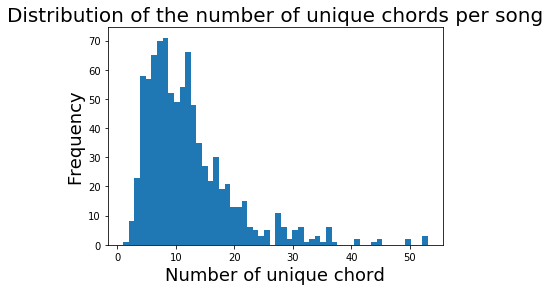

In [21]:
#Basic statistics: Number of unique chords per songs
unique_chord_songs = collection_df[[SONG_ID,CHORD]].drop_duplicates().groupby(SONG_ID).count()
n_bins = int(unique_chord_songs.max())+1
unique_chord_songs.plot.hist(bins = n_bins, legend = False)
plt.title('Distribution of the number of unique chords per song', fontsize = 20)
plt.xlabel('Number of unique chord', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.show()

# Milestone 3

## Squeezed dataframe

First, we define a function to obtain a dataframe with all the chords of a song squeezed in its various sections (intro, first verse, chorus, second verse...).

In [191]:
#The squeeze function returns a dataframe with the all the chords of a song squeezed in a row dependent on a subgroup
# of the section type. Default is "none" and will not filter any type of songs.
#try subgroup="chorus" or subgroup="verse"

def compress(s) :
    return s.dropna().to_list()

def squeeze(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
        
    return pd.DataFrame(df_local.groupby(["song_id","title"]).chord.agg(compress)).reset_index()

In [193]:
#squeeze section allows you to squeeze the sections of songs
def squeeze_section(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
        
    return pd.DataFrame(df_local.groupby(["song_id","sequence_id","section_type"]).chord.agg(compress)).reset_index()

In [194]:
squeeze_section(collection_df).head(5)

,song_id,sequence_id,section_type,chord
0,3,0,silence,[]
1,3,1,intro,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m..."
2,3,2,verse,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m..."
3,3,3,verse,"[A:maj, A:maj, C:maj, C:maj, A:maj, A:maj, C:m..."
4,3,4,interlude,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m..."


In [192]:
squeeze(collection_df,"chorus").head(5)

,song_id,title,chord
0,4,You've got a Friend,"[Ab:maj, Ab:7, Db:maj, Db:maj, Ab:maj, Ab:maj,..."
1,10,An Innocent Man,"[C:maj, C:maj, F:maj/5, C:maj, C:maj, F:maj/3,..."
2,12,Lookin' for Love,"[D:maj, D:maj, F#:min, F#:min, G:maj, G:maj, E..."
3,16,She Bop,"[D:min, D:min, C:maj, F:maj, G:maj, E:7, A:min..."
4,18,Kiss On My List,"[C:maj, G:maj/11, A:min/b3, G:maj/11, C:min7, ..."


## Parser for the chords 

We also define a parser to better handle the chords. This is based on the notation defined in http://ismir2005.ismir.net/proceedings/1080.pdf. Some notations are also added by the authors of the dataset and therefore included to handle all the 989 unique chords in the dataset. 

In [26]:
print('There are %d unique chords in the dataset.' %len(collection_df.chord.unique()))

There are 989 unique chords in the dataset.


In [27]:
#Split a string and changes the target field depending on which side of the split to take
#side : 0 for left and 1 for right
def split_add(c,dic,split_char,target,side):
    temp=str.split(str(c),split_char)

    dic[target]=temp[side]
    return dic, temp[1-side]


def chord_to_tab(c):
    c=str(c)
    chord={"root":"", "shorthand" : "", "degree_list":[], "bass":"", "N" :False}
    rest=""
    
    if(c=="N"):
        chord["N"] = True
        return chord
    
    c=c.replace(")","")
    
    if('/' in c):
        chord, rest=split_add(c,dic=chord,split_char="/",target="bass",side=1)
    else :
        rest=c
    if(':' in rest):
        chord, rest=split_add(rest,dic=chord,split_char=":",target="root",side=0)
    if('(' in rest):
        chord, rest=split_add(rest,dic=chord,split_char="(",target="degree_list",side=1)
    if(rest != ""):
        chord["shorthand"]=rest
    
    return chord

    

In [28]:
collection_df["chord_dic"]=collection_df.chord.map(lambda y : chord_to_tab(y))
for key in ['root', 'shorthand', 'degree_list', 'bass', 'N']:
    collection_df[key] = collection_df.chord_dic.map(lambda y: y[key])
df = collection_df[['song_id', 'title', 'artist', 'section_type', 'sequence_id', 'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N']]

In [29]:
df.head()

,song_id,title,artist,section_type,sequence_id,chord,root,shorthand,degree_list,bass,N
0,3,I Don't mind,James Brown,silence,0,NaN,,nan,[],,False
1,3,I Don't mind,James Brown,intro,1,A:min,A,min,[],,False
2,3,I Don't mind,James Brown,intro,1,A:min,A,min,[],,False
3,3,I Don't mind,James Brown,intro,1,C:maj,C,maj,[],,False
4,3,I Don't mind,James Brown,intro,1,C:maj,C,maj,[],,False


In [30]:
shorthand=['maj','min','dim','aug','maj7','min7', '7','dim7','hdim7',
           'minmaj7','maj6', 'min6','9', 'maj9', 'min9','sus4','11','maj11','min11','maj13','min13','sus2'] 

## Chord distribution

We can now analyse the distribution of chords (or elements of it such as the root or the quality) in the songs and in specific sections such as the verse and the chorus.

### Most common chords used

We can start by finding the most used chords in a given section. By default we look at the 50 most common chords.

In [31]:
def chord_distribution(section = 'verse', top = 50):
    title = 'Chord distribution in the ' + section
    df[df.section_type == section].chord.value_counts().iloc[:top].iplot(kind='bar',
                                                      title=title,
                                                      xTitle="Chord",
                                                      yTitle="Occurence")

In [32]:
chord_distribution('verse')

In [33]:
chord_distribution('chorus')

### Distribution of unique chords

We can also look at the distribution of unique chords used in songs.

In [34]:
def unique_chords_section(section = 'verse'):
    unique_chords = df[df.section_type == section].groupby(SONG_ID).count().title #Are we counting duplicates?
    n_bins = int(unique_chords.max()) + 1
    unique_chords.plot.hist(bins = int(n_bins/10), legend = False)
    title = 'Distribution of the number of unique chords per song in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Number of unique chords used', fontsize = 18)
    plt.ylabel('Frequency', fontsize = 18)
    plt.show()
    
    print(unique_chords.describe())

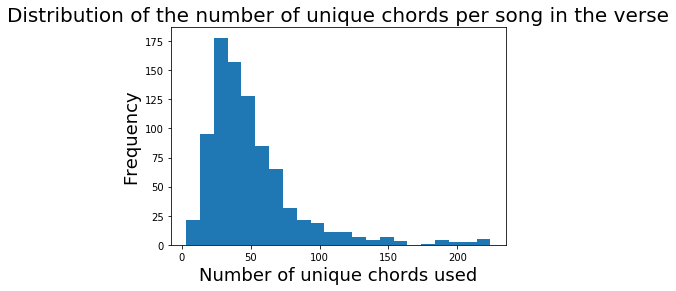

count    858.000000
mean      49.948718
std       33.518899
min        3.000000
25%       32.000000
50%       42.000000
75%       60.000000
max      224.000000
Name: title, dtype: float64


In [35]:
unique_chords_section('verse')

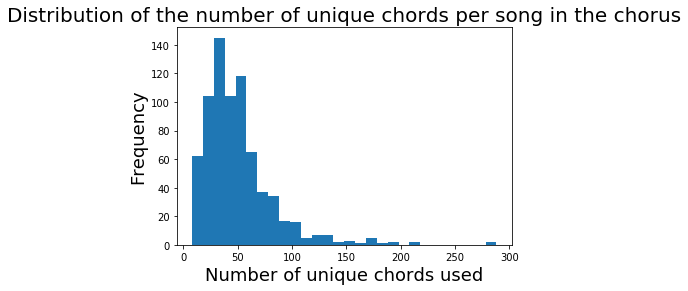

count    739.000000
mean      49.631935
std       33.286672
min        8.000000
25%       30.000000
50%       42.000000
75%       61.000000
max      288.000000
Name: title, dtype: float64


In [36]:
unique_chords_section('chorus')

### Root distribution

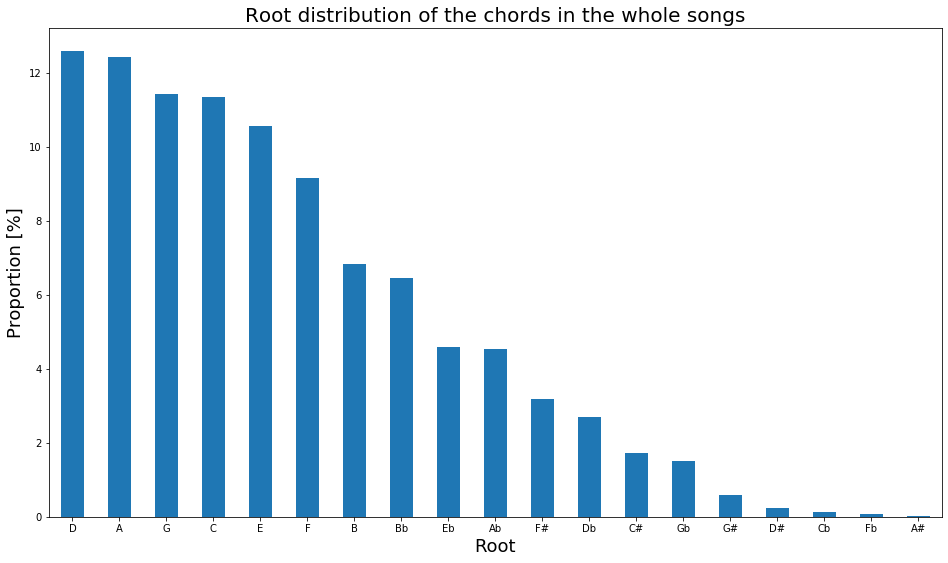

In [37]:
root_dist = df.root.value_counts()
#We remove the missing values (marked with an empty space by our parser)
root_dist.drop('', inplace = True)
#Plot
plt.figure(figsize = (16,9))
root_dist.map(lambda x: 100 * x / root_dist.sum()).plot(kind = 'bar')
plt.title('Root distribution of the chords in the whole songs', fontsize = 20)
plt.xlabel('Root', fontsize = 18)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

In [38]:
def root_distribution_section(section = 'verse', index = 1):
    root_dist = df[df.section_type == section].root.value_counts()
    #We remove the non-roots notation elements
    if '' in root_dist.index:
        root_dist.drop('', inplace = True) 

    #Plot
    plt.figure(figsize = (16,9))
    plt.subplot(2, 1, index)
    root_dist.map(lambda x: 100 * x / root_dist.sum()).plot(kind = 'bar')
    title = 'Root distribution of the chords in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Root', fontsize = 18)
    plt.xticks(rotation = 'horizontal')
    plt.ylabel('Proportion [%]', fontsize = 18)
    plt.show()

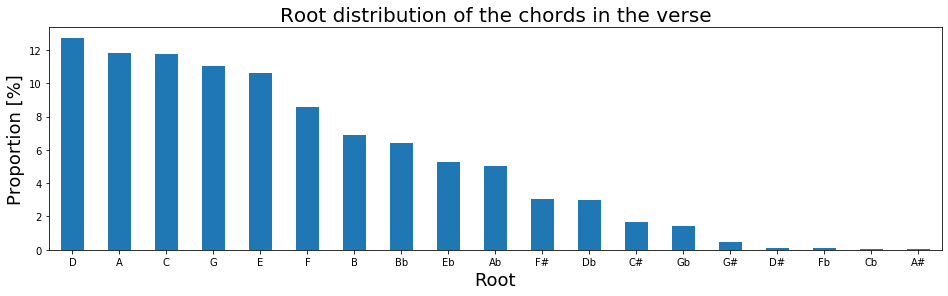

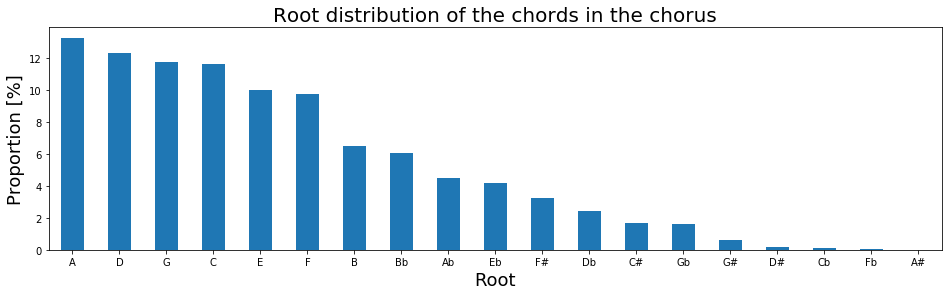

In [39]:
root_distribution_section('verse', 1)
root_distribution_section('chorus', 2)

### Quality distribution

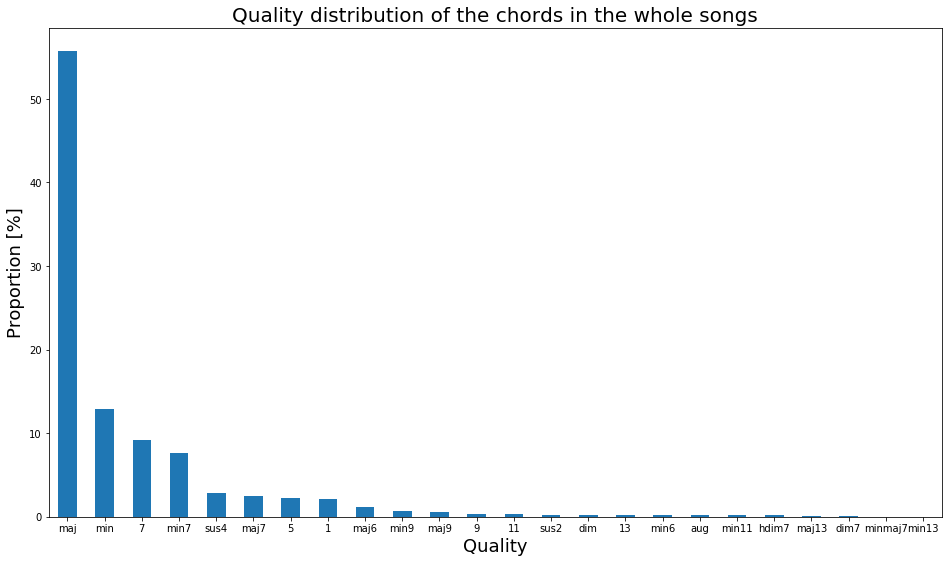

In [40]:
quality_dist = df.shorthand.value_counts()
#We remove the missing values (marked with an empty space by our parser)
quality_dist.drop(['nan', '', '*', '&pause'], inplace = True)
#Plot
plt.figure(figsize = (16,9))
quality_dist.map(lambda x: 100 * x / quality_dist.sum()).plot(kind = 'bar')
plt.title('Quality distribution of the chords in the whole songs', fontsize = 20)
plt.xlabel('Quality', fontsize = 18)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

In [41]:
def quality_distribution_section(section = 'verse'):
    quality_dist = df[df.section_type == section].shorthand.value_counts()
    #We remove the non-roots notation elements
    extra_notations = ['nan', '', '*', '&pause']
    for notation in extra_notations:
        if notation in quality_dist.index:
            quality_dist.drop(notation, inplace = True) 

    #Plot
    plt.figure(figsize = (16,9))
    plt.subplot(2, 1, 1)
    quality_dist.map(lambda x: 100 * x / quality_dist.sum()).plot(kind = 'bar')
    title = 'Quality distribution of the chords in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Quality', fontsize = 18)
    plt.xticks(rotation = 'horizontal')
    plt.ylabel('Proportion [%]', fontsize = 18)
    plt.show()

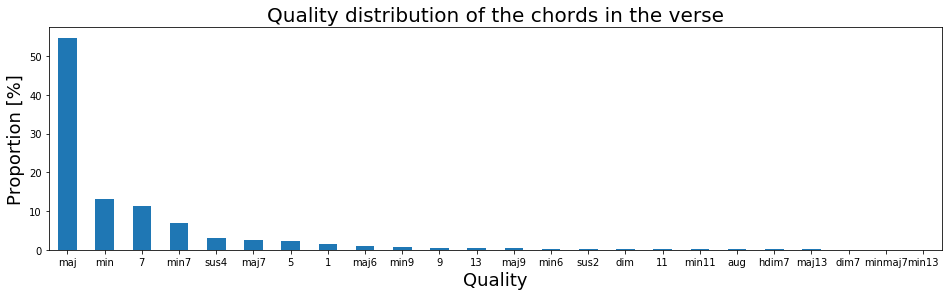

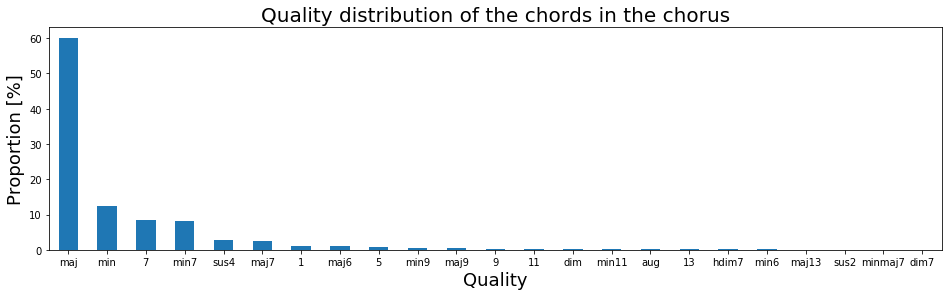

In [42]:
quality_distribution_section('verse')
quality_distribution_section('chorus')

### Bass note distribution

As we can see in the following plot, most chords do not use a bass note. We will therefore exclude this case in order to better observe which notes are more commonly used as bass notes.

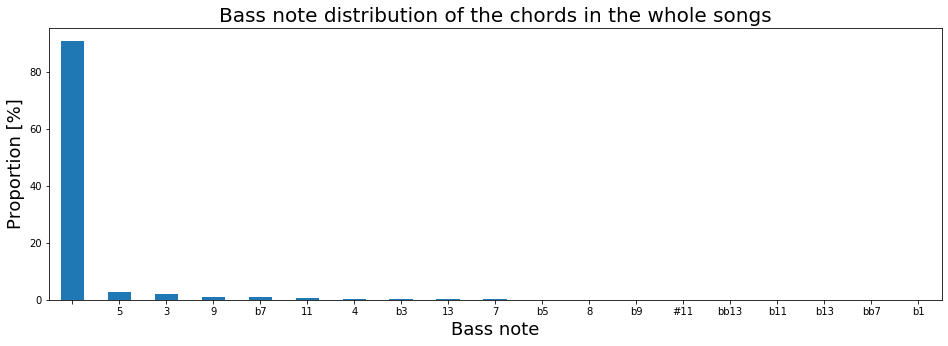

In [43]:
bass_note_dist = df.bass.value_counts()
#Plot
plt.figure(figsize = (16,5))
bass_note_dist.map(lambda x: 100 * x / bass_note_dist.sum()).plot(kind = 'bar')
plt.title('Bass note distribution of the chords in the whole songs', fontsize = 20)
plt.xlabel('Bass note', fontsize = 18)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

In [44]:
def bassnote_distribution_section(section = 'verse'):
    bass_note_dist = df[df.section_type == section].bass.value_counts()
    #We remove the non-roots notation elements
    if '' in bass_note_dist.index:
        bass_note_dist.drop('', inplace = True) 

    #Plot
    plt.figure(figsize = (16,9))
    plt.subplot(2, 1, 1)
    bass_note_dist.map(lambda x: 100 * x / bass_note_dist.sum()).plot(kind = 'bar')
    title = 'Bass note distribution of the chords in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Bass note', fontsize = 18)
    plt.xticks(rotation = 'horizontal')
    plt.ylabel('Proportion [%]', fontsize = 18)
    plt.show()

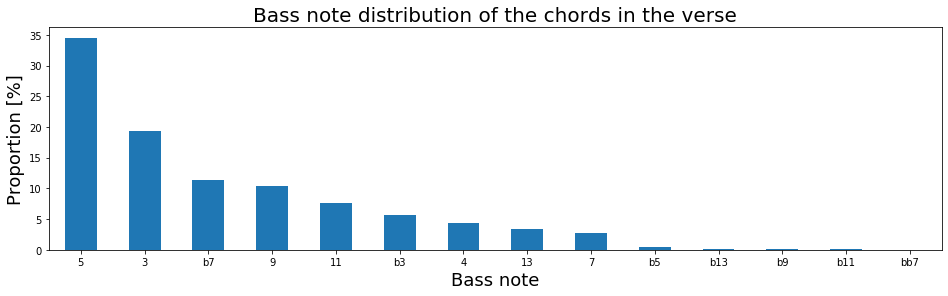

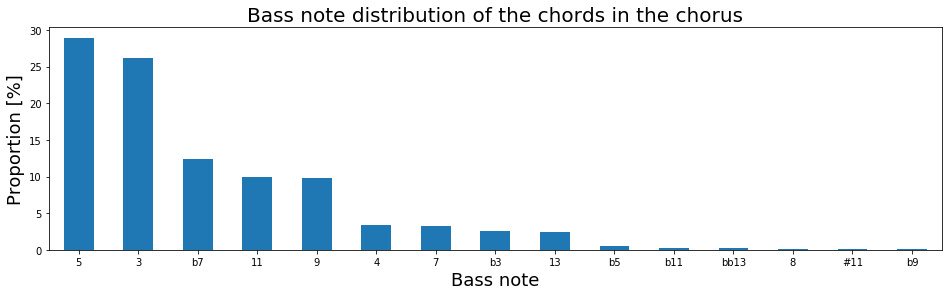

In [45]:
bassnote_distribution_section('verse')
bassnote_distribution_section('chorus')

### BoW representation

Let's start by creating a function to compute the Bag of Words representation of each song (or part of a song). In this case, the words will be all the possible chords.

In [88]:
vocab = dict.fromkeys(df.chord.unique(), 0) #Need to remove non-chord elements

In [138]:
def createBOW(chord_list):
    bow = vocab
    for chord in chord_list:
        if chord in vocab.keys():
            bow[chord] += 1
    #Normalise the BoW to get a distribution
    total = sum(bow.values())
    bow = {chord: count/total for chord, count in bow.items()}
    return bow.values()

We can then start to compute the BoW representation of the whole songs, using the function squeeze() previously created to help us.

In [199]:
df_bow = squeeze(collection_df)
df_bow['bow'] = df_squeezed.chord.map(lambda x: createBOW(x))

In [202]:
df_bow.head()

,song_id,title,chord,bow
0,3,I Don't mind,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m...","(6.313214346779603e-06, 0.017379752995488683, ..."
1,4,You've got a Friend,"[Ab:maj, Db:maj/5, Ab:maj, G:hdim7, C:7, F:min...","(6.3129187569442105e-06, 0.017378939261304332,..."
2,6,The Rose,"[C:5, C:maj, G:maj/3, F:maj/3, F:maj/3, F:maj/...","(6.312636477885519e-06, 0.017378162170579012, ..."
3,10,An Innocent Man,"[C:maj, C:maj, C:maj, D:min, D:min, F:maj, G:m...","(6.311925910613661e-06, 0.017376206038093527, ..."
4,12,Lookin' for Love,"[E:min, F#:min, G:maj, A:maj, E:min, F#:min, G...","(6.311500974863921e-06, 0.017375036225385804, ..."


Let's check each bow value is indeed a distribution (ie the sum of the elements is 1).

In [203]:
df_bow.bow.map(lambda x: sum(x)).sort_values()

854    1.0
469    1.0
387    1.0
771    1.0
31     1.0
      ... 
799    1.0
71     1.0
798    1.0
270    1.0
830    1.0
Name: bow, Length: 890, dtype: float64

We will do the same for the chorus and the verse section of songs.

In [208]:
df_bow_verse = squeeze(collection_df, 'verse')
df_bow_verse['bow'] = df_bow_verse.chord.map(lambda x: createBOW(x))

In [209]:
df_bow_verse.head()

,song_id,title,chord,bow
0,3,I Don't mind,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m...","(5.796684200026182e-06, 0.01737556088957848, 0..."
1,4,You've got a Friend,"[F:min, C:7/5, C:7, F:min, C:7/5, F:min/b3, C:...","(5.796647798578083e-06, 0.017375451776237803, ..."
2,6,The Rose,"[C:maj, G:maj/3, F:maj/3, F:maj/3, F:maj/3, G:...","(5.79641260024171e-06, 0.017374746769224528, 0..."
3,10,An Innocent Man,"[C:maj, C:maj, D:min, D:min, F:maj, G:maj, G:m...","(5.796197018532857e-06, 0.01737410056305224, 0..."
4,12,Lookin' for Love,"[G:maj, G:maj, D:maj, D:maj, G:maj, D:maj, A:m...","(5.79609623258575e-06, 0.017373798457175786, 0..."


In [210]:
df_bow_chorus = squeeze(collection_df, 'chorus')
df_bow_chorus['bow'] = df_bow_chorus.chord.map(lambda x: createBOW(x))

In [211]:
df_bow_chorus.head()

,song_id,title,chord,bow
0,4,You've got a Friend,"[Ab:maj, Ab:7, Db:maj, Db:maj, Ab:maj, Ab:maj,...","(5.6791453264893325e-06, 0.017381024271720603,..."
1,10,An Innocent Man,"[C:maj, C:maj, F:maj/5, C:maj, C:maj, F:maj/3,...","(5.678828192731857e-06, 0.01738005368385585, 0..."
2,12,Lookin' for Love,"[D:maj, D:maj, F#:min, F#:min, G:maj, G:maj, E...","(5.678653515536086e-06, 0.017379519084298193, ..."
3,16,She Bop,"[D:min, D:min, C:maj, F:maj, G:maj, E:7, A:min...","(5.6785084072683015e-06, 0.017387592743055538,..."
4,18,Kiss On My List,"[C:maj, G:maj/11, A:min/b3, G:maj/11, C:min7, ...","(5.67842779476837e-06, 0.01738734590758075, 0...."
